In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 

from dataloader.dataloader import data_generator
from sklearn.metrics import f1_score, accuracy_score
from models.loss import SinkhornDistance
from pytorch_metric_learning import losses
from algorithms.RAINCOAT import RAINCOAT
from models.models import classifier


#### Problem Statement

**Domain Adaptation**: Given the source and target domain time series datasets, $D^{S}$ and $D^{T}$, and target labels $y^t$ are not available at train time. Raincoats specifies a strategy to train a classifier $f$ on ${D}^S$ such that $f$ generalizes to ${D}^T$, i.e., it minimizes classification risk on ${D}^T$: ${E}_{x_i, y_i \sim {D}^T}\left[{C}(f(x_i), y_i)\right]$, where $C$ is a classification loss function.

##### We begin by defining configurations and loading source and target datasets

As a demonstration, we utilize the WISDM dataset, which comprises 3-axis accelerometer measurements acquired from 30 participants. The measurements were captured at a frequency of 20 Hz. Within the dataset, there are six distinct activity labels: walking, jogging, sitting, standing, walking upstairs, and walking downstairs.

In the context of domain adaptation, the participants themselves define the domains. For this particular example, we designate participant 2 as the source domain, from which we draw our training data, and participant 32 as the target domain, where our objective lies in generalizing the learned knowledge.

In [2]:
class WISDM_config():
    def __init__(self):
        super(WISDM_config, self)
        self.class_names = ['walk', 'jog', 'sit', 'stand', 'upstairs', 'downstairs']
        self.sequence_len = 128
        # Transfer scenarios, e.g., from source domain 2 to target domain 32
        self.scenarios = [("2", "32"), ("4", "15"),("7", "30"),('12','7'), ('12','19'),('18','20'),\
                          ('20','30'), ("21", "31"),("25", "29"), ('26','2')]

        self.num_classes = 6
        self.shuffle = True
        self.drop_last = False
        self.normalize = True

        # model configs
        self.input_channels = 3
        self.kernel_size = 5
        self.stride = 1
        self.dropout = 0.5
        self.num_classes = 6
        self.width = 64  
        # for Fourier Frequency Feature Extration, number of modes to keep 
        self.fourier_modes = 64  
        # features
        self.mid_channels = 64
        self.final_out_channels = 128
        self.out_dim = self.final_out_channels+ self.fourier_modes * 2
        self.features_len = 1


data_path = './data/WISDM'
src_id = '2'
trg_id = '32'
dataset_configs = WISDM_config()
hparams = {"batch_size":64, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 100}

src_train_dl, src_test_dl = data_generator(data_path, src_id,dataset_configs, hparams)
trg_train_dl, trg_test_dl = data_generator(data_path, trg_id, dataset_configs,hparams)

Visulize a time series sample

Text(0.5, 1.0, 'Activity (label) is Walking')

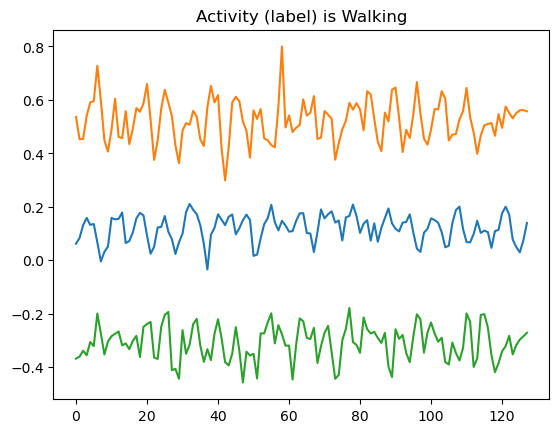

In [3]:
src_x, src_y = src_train_dl.dataset.x_data[0], src_train_dl.dataset.y_data[0]
plt.plot(src_x.t())
plt.title(f'Activity (label) is Walking')

#### We begin by highlighting the significance of frequency features in DA for time series.

Domain adaptation revolves around the fundamental concept of extracting domain-invariant features between source and target domains. In this context, the accompanying figure showcases the sensor readings of walking activity from two distinct individuals (denoted as 4 and 15). The primary objective of domain adaptation methods is to train an encoder capable of projecting source and target domain features as closely aligned as feasible. To address the underlying time feature shift or discrepancy assumption, several methods have been proposed for achieving feature alignment. It is important to note that, for the sake of simplicity, only the first sensor reading is visualized in the provided illustration.

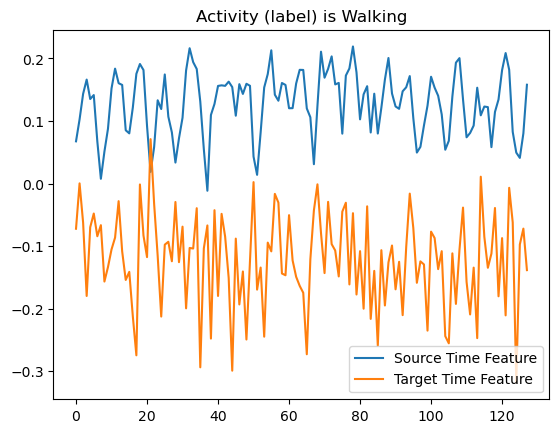

In [4]:
src_x, src_y = src_train_dl.dataset.x_data[2], src_train_dl.dataset.y_data[2]
trg_x, trg_y = trg_train_dl.dataset.x_data[1], trg_train_dl.dataset.y_data[1]
assert src_y == trg_y  # Ensure two selected samples have the same label
plt.plot(src_x.t()[:,0], label='Source Time Feature')
plt.plot(trg_x.t()[:,0], label='Target Time Feature')
plt.title(f'Activity (label) is Walking')
plt.legend()

##### Frequency Features Promote Domain Adaptation
Researchers demonstrated that the performance of DA techniques is bounded by the divergence between the source and target domains, and that a small feature shift is necessary for DA techniques to be effective. However, unsupervised DA methods for time series align only time features, leading to sub-optimal performance when the time feature shift is large. 

By including frequency features in the encoder, we can uncover potential invariant features across domains and improve transferability. The accompanying figure showcases the frequency features of walking activity from two distinct individuals (denoted as 4 and 15) in the polar coordinates. As shown in the figure below, frequency features from different domains do not exhibit significant feature shifts and thus are domain invariant. This suggests that incorporating frequency features can lead to more accurate predictions in the target domain as DA aims to extract domain-invariant features.For this reason, Raincoat uses both time and frequency features in domain alignment.

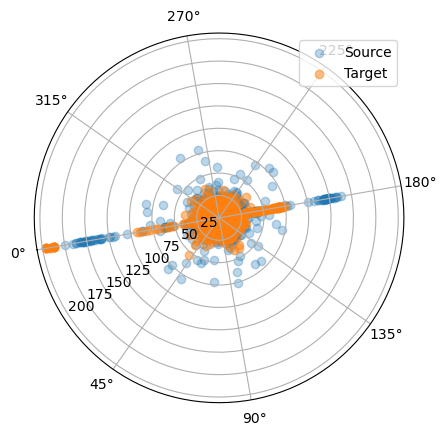

In [5]:
src_x = src_train_dl.dataset.x_data
trg_x = trg_train_dl.dataset.x_data
# Extract frequency features for the source domain
x_ft_src = torch.fft.rfft(src_x)
r_src = x_ft_src[:,0,:32].abs()
p_src = x_ft_src[:,0,:32].angle() 
# Extract frequency features for the target domain
x_ft_trg = torch.fft.rfft(trg_x)
r_trg = x_ft_trg[:,0,:32].abs()
p_trg = x_ft_trg[:,0,:32].angle() 

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(p_src, r_src, alpha=0.3, label='Source')
c = ax.scatter(p_trg, r_trg, alpha=0.5, label='Target')


ax.set_theta_zero_location('W', offset=10)
ax.legend(loc='best')

### The algorithm of Raincoat: 

Raincoat consists of two essential steps, namely alignment and correction, which involve three modules:

1. The time-frequency encoder $G_{Time, Freq}$ plays a crucial role in the alignment step. It concatenates the outputs from two modules, namely Spectral1d (frequency feature encoder) and CNN (time feature encoder). **TIme Feature Extactor:** Regarding the time feature extraction, we adopt the Convolutional Neural Network from AdaTime. It consists of two layers of convolution blocks. Each block performs Convolution 1d BatchNorm, ReLu, Maxpool and Dropout sequentially. 

2. The classifier $H$ is responsible for making predictions and is defined above Spectral1d. 

3. The auxiliary decoder $U_{Time, Freq}$, referred to as tf_decoder, is defined below.

During the initial alignment step, Raincoat trains a classifier $H$ using the labeled source dataset $D^S$. Additionally, it utilizes the feature encoder $G_{Time, Freq}$ and decoder $U_{Time, Freq}$, incorporating both $D^S$ and $D^T$. Simultaneously, it aligns the target features $z^t_i$ with the source features $z^s_i$ by leveraging Sinkhorn divergence. The overall loss function in this step consists of three terms.

1. The sinkhorn distance $L_{A}(z^t_i, z^s_i)$ encourages alignment between the target features $z^t_i$ and the source features $z^s_i$.

2. The reconstruction loss $L_R(x^s_i, U_{Time, Freq}(G_{Time, Freq}(x^s_i)))" promotes the learning of semantic features from the labeled source dataset $D^S$.

3. The classification loss $L_C(H(G_{Time, Freq}(x^s_i)), y^s_i)$ guides the model in correctly classifying the samples.

To summarize, the loss in this alignment step is defined as $L = \lambda_1 L_A + \lambda_2 L_R + \lambda_3 L_C$ and is specified in the Raincoat.update() function.

In addition to the alignment step, Raincoat incorporates a correction step to address potential negative transfer, particularly for target unknown samples. This step involves exploiting target-specific discriminative features by minimizing $L_R(x^t_i, U_{Time, Freq}(G_{Time, Freq}(x^t_i)))$. The implementation of this correction step can be found in the Raincoat.correct() function.


#### Frequency Feature Extractor: 

In Raincoat, we develop a frequency feature extractor based on Fourier Transform. 
Given a time series $x_i$, the frequency feature encoder, defined as SpectralConv1D bewlo, extracts both amplitutde $r$ and phase $p$ feature by performing a parameterized convolutional. 

We summarize how it encodes time-frequency feature from $x_i$. Define a convolution operator ``$\ast$" and weight matrix $\mathbf{B}$, the encoder encodes frequency features $e_{Freq,i}$ by:

1. Smooth: $x_i =\operatorname{Smooth}(x_i)$
2. DFT: $v_i =\operatorname{DFT}(x_i)$
3. Convolution: $\tilde{v}_{i}= \mathbf{B} \ast v_i$
4. Transform: $r_i, p_i \leftarrow \tilde{v}_{i} $
5. Extract: $ e_{Freq, i} = [r_i;p_i] $


In [6]:
def eval(algorithm, loader, final=False):
    device = 'cuda'
    feature_extractor = algorithm.feature_extractor.to(device)
    classifier = algorithm.classifier.to(device)
    if final == True:
        feature_extractor.load_state_dict(torch.load('backbone.pth'))
        classifier.load_state_dict(torch.load('classifier.pth'))
    feature_extractor.eval()
    classifier.eval()
    trg_pred_labels = np.array([])
    trg_true_labels = np.array([])
    with torch.no_grad():
        for data, labels in loader:
            data = data.float().to(device)
            labels = labels.view((-1)).long().to(device)
            features,_ = feature_extractor(data)
            predictions = classifier(features)

            pred = predictions.detach().argmax(dim=1)  # get the index of the max log-probability

            trg_pred_labels = np.append(trg_pred_labels, pred.cpu().numpy())
            trg_true_labels = np.append(trg_true_labels, labels.data.cpu().numpy())
    accuracy = accuracy_score(trg_true_labels, trg_pred_labels)
    f1 = f1_score(trg_pred_labels, trg_true_labels, pos_label=None, average="macro")
    return accuracy *100, f1

#### Training 

In [7]:

device = 'cuda'
algorithm = RAINCOAT(dataset_configs, hparams,device)
algorithm.to(device)
best_f1 = 0
### Alignment
for i in range(hparams['num_epochs']):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        loss = algorithm.update(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')

tar_acc, tar_f1 = eval(algorithm, trg_test_dl,final=True)
print(f'Target Accuracy before correction:{tar_acc}, Target F1:{tar_f1}')

### Correction 
for i in range(10):
    joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
    for step, ((src_x, src_y), (trg_x, _)) in joint_loaders:
        src_x, src_y, trg_x = src_x.float().to(device), src_y.long().to(device), \
                                trg_x.float().to(device)
        loss = algorithm.correct(src_x, src_y, trg_x)

    acc, f1 = eval(algorithm, src_train_dl)
    if f1>=best_f1:
        best_f1 = f1
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.classifier.state_dict(), 'classifier.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation Accuracy on Source Test is {acc}')
tar_acc, tar_f1 = eval(algorithm, trg_train_dl,final=True)
print(f'Target Accuracy after correction:{tar_acc}, Target F1:{tar_f1}')

Epoch 0: Validation Accuracy on Source Test is 10.9375
Epoch 10: Validation Accuracy on Source Test is 58.59375
Epoch 20: Validation Accuracy on Source Test is 68.75
Epoch 30: Validation Accuracy on Source Test is 70.3125
Epoch 40: Validation Accuracy on Source Test is 78.90625
Epoch 50: Validation Accuracy on Source Test is 82.8125
Epoch 60: Validation Accuracy on Source Test is 92.1875
Epoch 70: Validation Accuracy on Source Test is 93.75
Epoch 80: Validation Accuracy on Source Test is 95.3125
Epoch 90: Validation Accuracy on Source Test is 99.21875
Target Accuracy before correction:72.46376811594203, Target F1:0.59290077011596
Epoch 0: Validation Accuracy on Source Test is 99.21875
Target Accuracy after correction:78.125, Target F1:0.6343399148277197
